In [2]:
import copy
import csv
import glob
import importlib
import itertools
import operator
import os
import random
import time
from math import exp, log, pi, sqrt
from os.path import *

import keras.layers as layers
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from numba import njit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import cnn_builder as cbuild
import cnn_runner as crun
import config
import ddpg.learning_nets as ln
import ddpg.task_nets as tn
import dr_methods as drm
import feature_interpretation as cnna
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import voi_methods as vm

%matplotlib inline
np.set_printoptions(4)

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
importlib.reload(tn)
T = tn.TaskNets()
#model = T.build_reg_network()
#model.summary(120)

In [8]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.initializers import Constant
from keras.models import Model
from keras import backend as K

In [24]:
N = 100
nb_epoch = 10
batch_size = 20
nb_features = 1024
Q = 1
D1 = 3  # first output
D2 = 3  # second output

In [18]:
def gen_data(N):
    X = np.random.randn(N, Q)
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    w2 = 3
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2

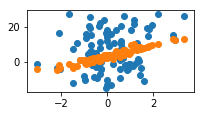

In [6]:
import pylab
%matplotlib inline

X, Y1, Y2 = gen_data(N)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])
pylab.show()

In [30]:
X = np.random.randn(N, Q)
Y1 = np.random.randint(0,3,(N))
Y2 = np.random.randint(0,3,(N))
Y1 = np_utils.to_categorical(Y1,3).astype(int)
Y2 = np_utils.to_categorical(Y2,3).astype(int)

In [37]:
importlib.reload(tn)
def get_prediction_model():
    inp = Input(shape=(Q,), name='inp')
    x = Dense(nb_features, activation='relu')(inp)
    y1_pred = Dense(3,activation='softmax')(x)
    y = Dense(1)(x)
    y1_pred = layers.Concatenate()([y1_pred, y])
    y2_pred = Dense(3,activation='softmax')(x)
    z = Dense(1)(x)
    y2_pred = layers.Concatenate()([y2_pred, z])
    return Model(inp, [y1_pred, y2_pred])

def get_trainable_model(prediction_model):
    inp = Input(shape=(Q,), name='inp')
    y1_pred, y2_pred = prediction_model(inp)
    y1_true = Input(shape=(3,), name='y1_true')
    y2_true = Input(shape=(3,), name='y2_true')
    out = tn.CustomMultiLossLayer(nb_outputs=2)([y1_true, y2_true, y1_pred, y2_pred])
    return Model([inp, y1_true, y2_true], out)

prediction_model = get_prediction_model()
trainable_model = get_trainable_model(prediction_model)
trainable_model.compile(optimizer='adam', loss=None)
assert len(trainable_model.layers[-1].trainable_weights) == 2  # two log_vars, one for each output
assert len(trainable_model.losses) == 1

In [40]:
hist = trainable_model.fit([X, Y1, Y2], epochs=nb_epoch, batch_size=batch_size)

Epoch 1/10
100/100 [==============================] - 2s 21ms/step - loss: 11.8517
Epoch 2/10
100/100 [==============================] - 2s 21ms/step - loss: 10.7254
Epoch 3/10
100/100 [==============================] - 2s 21ms/step - loss: 9.8297
Epoch 4/10
100/100 [==============================] - 2s 21ms/step - loss: 9.1073
Epoch 5/10
100/100 [==============================] - 2s 20ms/step - loss: 8.5176
Epoch 6/10
100/100 [==============================] - 2s 20ms/step - loss: 8.0182
Epoch 7/10
100/100 [==============================] - 2s 21ms/step - loss: 7.5924
Epoch 8/10
100/100 [==============================] - 2s 21ms/step - loss: 7.2165
Epoch 9/10
100/100 [==============================] - 2s 20ms/step - loss: 6.8754
Epoch 10/10
100/100 [==============================] - 2s 21ms/step - loss: 6.5684


In [45]:
importlib.reload(tn)
M = tn.get_trainable_model()

ValueError: Dimensions must be equal, but are 3 and 24 for 'custom_multi_loss_layer_8/monte_carlo_results/while/add' (op: 'Add') with input shapes: [?,3,24,12,4], [4,12,24,21,?,3].

In [15]:
[np.exp(K.get_value(log_var[0]))**0.5 for log_var in trainable_model.layers[-1].log_vars]

[8.86788010097969, 0.9307303790294662]

In [46]:
A = np.array([[1,2,3],[4,5,6]])

In [47]:
A.shape

(2, 3)

In [48]:
np.reshape(A.flatten(),(2,3))

array([[1, 2, 3],
       [4, 5, 6]])

In [93]:
model.compile(optimizer=Adam(), loss="mse")

In [ ]:
prediction_model = get_prediction_model()
trainable_model = get_trainable_model(prediction_model)
trainable_model.compile(optimizer='adam', loss=None)
assert len(trainable_model.layers[-1].trainable_weights) == 2  # two log_vars, one for each output
assert len(trainable_model.losses) == 1
hist = trainable_model.fit([X, Y1, Y2], nb_epoch=nb_epoch, batch_size=batch_size, verbose=0)

[np.exp(K.get_value(log_var[0]))**0.5 for log_var in trainable_model.layers[-1].log_vars]

In [ ]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
importlib.reload(crun)
C = config.Config('etiology')
T = config.Hyperparams()
T.get_best_hyperparams()
T.epochs = 30
T.steps_per_epoch = 300

In [ ]:
importlib.reload(cbuild)
importlib.reload(dqna)
#dqn_generator = cbuild._train_gen_dqn([])
agent = dqna.train_dqn(dqn_generator, agent)

In [ ]:
agent.cls_model.fit(cls_generator)

In [9]:
T.padding = ['same', 'same']
T.pool_sizes = [(2,2,2),(2,2,2)]
T.f = [64,64,64,64,64,64,64]
T.skip_con = True
T.epochs = 20

In [ ]:
drm.dcm2npy_batch(acc_nums=["E100113043"])
#vm.reset_accnum('E105464882')

In [ ]:
vm.plot_check(2, "E102088195");

In [ ]:
vm.xref_dirs_with_excel()

In [ ]:
crun.run_fixed_hyperparams([C], hyperparams=T)#C_list)

In [9]:
importlib.reload(cbuild)
model = cbuild.build_cnn_hyperparams(T)
model.summary(line_length=120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_2 (InputLayer)                   (None, 24, 24, 12, 3)      0                                                     
________________________________________________________________________________________________________________________
lambda_4 (Lambda)                      (None, 24, 24, 12, 1)      0             input_2[0][0]                           
________________________________________________________________________________________________________________________
lambda_5 (Lambda)                      (None, 24, 24, 12, 1)      0             input_2[0][0]                           
________________________________________________________________________________________________________________________
lambda_6 (Lambda)               

In [ ]:
importlib.reload(cbuild)
#Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4)#, Z_test_fixed=Z_reader)
Z_test, Z_train_orig = Z
X_train_orig, Y_train_orig = train_orig
hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])#, callbacks=[T.early_stopping])

In [10]:
model.save(join(C.model_dir, "model_.hdf5"))

In [ ]:
model.predict(X_train_orig[20:40])

In [ ]:
Y_train_orig[:20]

In [ ]:
hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])#, callbacks=[T.early_stopping])

In [ ]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#save_output(Z_test, y_pred, y_true)

print(accuracy_score(y_true, y_pred))
#y_true_simp, y_pred_simp, _ = cnna.merge_classes(y_true, y_pred)
#print(accuracy_score(y_true_simp, y_pred_simp))